<h1>Анализ приложения (мобильная игра)</h1><br>

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. <br>
К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

1. В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
2. Помимо этого, в компании провели A/B тестирование наборов акционных предложений. <br>
     На основе имеющихся данных определите, какой набор можно считать лучшим <br>
     и на основе каких метрик стоит принять правильное решение.
3. Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

In [55]:
# Подключим библиотеки
import os

from datetime import datetime
from datetime import timedelta

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np

import scipy.stats as ss

### Задание 1

Retention – один из самых важных показателей в компании. <br>
Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). <br>
Данные лежат в папке shared и имеют следующую структуру:

- shared/problem1-reg_data.csv – данные о времени регистрации
- shared/problem1-auth_data.csv – данные о времени захода пользователей в игру

Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, <br>
так и на части (сэмпле) данных.

<h5>Cчитывание данных

In [56]:
# Запишем путь файла в переменную
path_reg = "~/shared/problem1-reg_data.csv"
path_auth = "~/shared/problem1-auth_data.csv"

# Cчитаем DF c помощью лямбда-функции
download_df = lambda x:  pd.read_csv(x, sep=';')

# Присвоим переменную датафрейму
df_reg = download_df(path_reg)
df_auth = download_df(path_auth)

<h5>Проверка данных

In [57]:
# Размеры DF
print("Размер таблицы о времени регистрации: \n{}".format(df_reg.shape), "\n")
print("Размер таблицы о времени захода пользователей в игру: \n{}".format(df_auth.shape))

Размер таблицы о времени регистрации: 
(1000000, 2) 

Размер таблицы о времени захода пользователей в игру: 
(9601013, 2)


In [4]:
# Типы данных DF
print("Форматы колонок таблицы о времени регистрации:\n{}".format(df_reg.dtypes), '\n')
print("Форматы колонок таблицы о времени захода пользователей в игру:\n{}".format(df_auth.dtypes))

Форматы колонок таблицы о времени регистрации:
reg_ts    int64
uid       int64
dtype: object 

Форматы колонок таблицы о времени захода пользователей в игру:
auth_ts    int64
uid        int64
dtype: object


In [5]:
# Отсутствующие значения в данных DF
print("Число пропусков в колонках таблицы о времени регистрации:\n{}".format(df_reg.isna().sum()), '\n')
print("Число пропусков в колонках таблицы о времени захода пользователей в игру:\n{}".format(df_auth.isna().sum()))

Число пропусков в колонках таблицы о времени регистрации:
reg_ts    0
uid       0
dtype: int64 

Число пропусков в колонках таблицы о времени захода пользователей в игру:
auth_ts    0
uid        0
dtype: int64


С исходными данными проблем нет, все форматы соответствуют действительности, дата в виде таймстемпов (следует перевести в формат datetime).

Так как в количество данных очень большое, имеет смысл писать функцию на определенном срезе - выберем последний месяц

<h5>Функция RETENTION (за последний месяц)</h5>



In [6]:
def calc_retenrion_func(df_registrations, df_authorizations):
    """
    Функция подсчёта Retention за последний месяц.
    На вход:
        1 аргумент - Таблица с таймстемпами регистраций юзеров;
        2 аргумент - Таблица с таймстемпами авторизаций юзеров.
    На выход:
        Теловая карта Retention за последний месяц.
    """
    
    # Преобразуем временные метки в формат даты (отбросим лишнее время)
    df_auth["auth_date"] = pd.to_datetime(df_auth.auth_ts, unit="s").dt.date
    df_reg["reg_date"] = pd.to_datetime(df_reg.reg_ts, unit="s").dt.date

    # Объединим датафреймы в один
    df_reg_and_auth = df_auth.merge(df_reg, on="uid", how="left")

    # Посмотрим данные с регистрациями юзеров за последний месяц
    # Выберем самую последнюю дату
    last_date = df_reg_and_auth['reg_date'].max() 
    # Отнимем от нее месяц
    start_date = last_date - pd.DateOffset(months=1)
    # Отфильтруем DF по дате
    df_reg_and_auth = df_reg_and_auth[df_reg_and_auth['reg_date'] >= start_date]

    # Вычислим число дней с момента регистрации до авторизации
    df_reg_and_auth['count_days_from_reg'] = (df_reg_and_auth.auth_date - df_reg_and_auth.reg_date).dt.days

    # Cоздадим кросс-таблицу, отставим NaN для треугольной формы Heatmap
    table_retention = pd.crosstab([df_reg_and_auth['reg_date']], df_reg_and_auth['count_days_from_reg'], values=df_reg_and_auth['uid'], aggfunc='count')

    # Узнаем массив с количеством юзеров зарегистрировавшихся в данный день
    all_users_regs_in_day = table_retention.iloc[:, 0]

    # Посчитаем Retention за каждый день с момента регистрации юзеров
    table_retention = (table_retention.div(all_users_regs_in_day, axis=0) * 100).round(2)

    # Уберем 0-вой день, чтобы не захломлять таблицу очевидным
    table_retention = table_retention.iloc[:, 1:]


    # Визуализируем
    # Размер графика
    plt.figure(figsize=(20,20))

    # Heatmap
    sns.heatmap(table_retention, annot=True, fmt=".2f", cmap="YlGnBu",
                               linecolor='white', linewidths=2, cbar=False, square=True)

    # Сделаем подписи к графику
    plt.title('Retention игроков за последний месяц\nс момента их регистрации\n', size=45)
    plt.ylabel('Дата регистрации игроков', labelpad=15, size=20)
    plt.xlabel('Дни с момента регистрации', labelpad=15, size=20)

    # Увеличим масштаб подписей осей
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    
    return

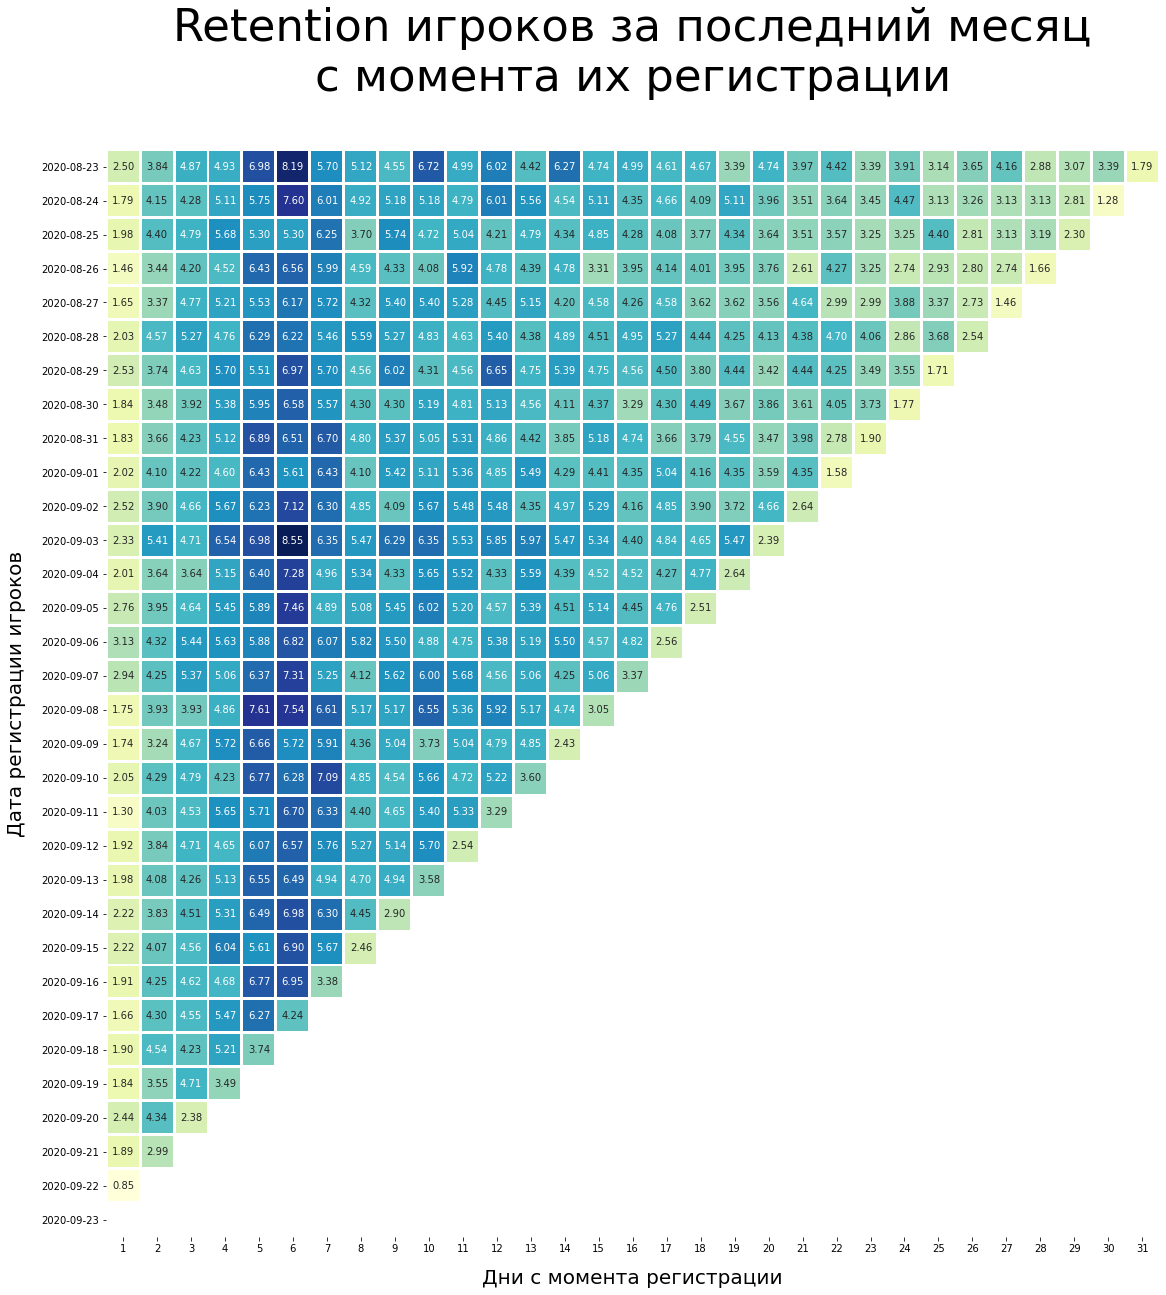

In [7]:
calc_retenrion_func(df_reg, df_auth)

<h4>Вывод по Заданию 1</h4>

В ходе задания, была реализована функция расчёта Retention за последний месяц (в целом можно было бы и в саму функцию задавать start_date и last_date тем самым очерчивать диапазон дат для просмотра метрики) от регистрации юзера.

### Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений.<br> Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? <br>
Какие метрики стоит проанализировать для принятия правильного решения и как?

<h5>Cчитывание данных

In [148]:
# Запишем путь файла в переменную
path_data = "/mnt/HC_Volume_18315164/home-jupyter/jupyter-o-mihalev/FinalProject/Проект_1_Задание_2.csv"

# Присвоим переменную датафрейму
df_data = download_df(path_data)
df_data

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


<h5>Проверка данных

In [149]:
# Размеры DF
print("Размер таблицы c данными A/B теста: \n{}".format(df_data.shape), "\n")

Размер таблицы c данными A/B теста: 
(404770, 3) 



In [150]:
# Типы данных DF
print("Форматы колонок таблицы c данными A/B теста:\n{}".format(df_data.dtypes))

Форматы колонок таблицы c данными A/B теста:
user_id       int64
revenue       int64
testgroup    object
dtype: object


In [151]:
# Отсутствующие значения в данных DF
print("Число пропусков в колонках таблицы c данными A/B теста:\n{}".format(df_data.isna().sum()), '\n')

Число пропусков в колонках таблицы c данными A/B теста:
user_id      0
revenue      0
testgroup    0
dtype: int64 



In [152]:
# Проверим число уникальных юзеров
print('Число уникальных юзеров {} \
совпадает с числом строк таблицы с данными A/B теста {}.'.format(df_data.user_id.nunique(), df_data.shape[0]))

Число уникальных юзеров 404770 совпадает с числом строк таблицы с данными A/B теста 404770.


In [153]:
# Проверим количество групп таблице DF
print('В таблице с данными A/B теста всего имеется {0} группы.'.format(df_data.testgroup.nunique()))

В таблице с данными A/B теста всего имеется 2 группы.


С исходными данными проблем нет, все форматы соответствуют действительности, пропусков данных нет, каждая строчка соответствует уникальному пользователю, в таблице имеется всего 2 сравниваемые группы.

<h5>Анализ данных</h5>

In [154]:
# Создадим колонку в исходной таблице с фактом совершения покупки пользователем

df_data['purchase'] = df_data.revenue.apply(lambda x: bool(x))

# Разобъем данные на 2 группы

# DF группы А
df_data_A = df_data[df_data['testgroup'] == "a"]
print(f'Данные по группе А.\nКоличество пользователей в группе А = {df_data_A.shape[0]}')
print(f'Количество клиентов (платящих пользователей) в группе А = {df_data_A[df_data_A.revenue != 0].shape[0]}')
ARPU_A = df_data_A.revenue.sum() / df_data_A.shape[0]
print(f'ARPU в группе А = {ARPU_A.round(2)}')
CR1_A = df_data_A[df_data_A.revenue != 0].shape[0] / df_data_A.shape[0]
print(f'CR1 конверсия в клиента в группе А = {CR1_A}')
print(f'Общая выручка в группе А = {df_data_A.revenue.sum()}')

# DF группы B
df_data_B = df_data[df_data['testgroup'] == "b"]
print(f'\nДанные по группе B.\nКоличество пользователей в группе B = {df_data_B.shape[0]}')
print(f'Количество клиентов (платящих пользователей) в группе B = {df_data_B[df_data_B.revenue != 0].shape[0]}')
ARPU_B = df_data_B.revenue.sum() / df_data_B.shape[0]
print(f'ARPU в группе B = {ARPU_B.round(2)}')
CR1_B = df_data_B[df_data_B.revenue != 0].shape[0] / df_data_B.shape[0]
print(f'CR1 конверсия в клиента в группе B = {CR1_B}')
print(f'Общая выручка в группе B = {df_data_B.revenue.sum()}')

delta_ARPU = abs(1 - ARPU_B / ARPU_A) * 100
print(f'\nРазница в ARPU между тестовой (B) и контрольной (A) группами = {delta_ARPU.round(2)}%.')

Данные по группе А.
Количество пользователей в группе А = 202103
Количество клиентов (платящих пользователей) в группе А = 1928
ARPU в группе А = 25.41
CR1 конверсия в клиента в группе А = 0.009539690157988749
Общая выручка в группе А = 5136189

Данные по группе B.
Количество пользователей в группе B = 202667
Количество клиентов (платящих пользователей) в группе B = 1805
ARPU в группе B = 26.75
CR1 конверсия в клиента в группе B = 0.008906235351586593
Общая выручка в группе B = 5421603

Разница в ARPU между тестовой (B) и контрольной (A) группами = 5.26%.


<h5>Исследуем показатели всех пользователей

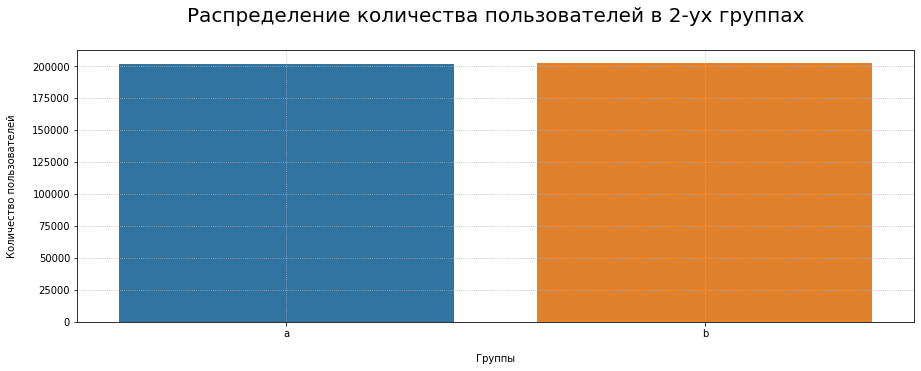

In [155]:
# Посмотрим общее количество пользователей в обоих группах с помощью барплота
# Размер графика
plt.figure(figsize=(15,5))

# Барплот 
sns.barplot(data=df_data.groupby("testgroup", as_index=False).agg({"user_id":"count"}),
                        x='testgroup', y='user_id', order=['a', 'b'])

# Подписи названию и осям графика
plt.title('Распределение количества пользователей в 2-ух группах\n', size=20)
plt.ylabel('Количество пользователей', labelpad=15, size=10)
plt.xlabel('Группы', labelpad=15, size=10)

# Легенда
#plt.legend(title="Группа")

# Подписи меток осей
plt.xticks(fontsize=10) #range(len(labels)), labels, , rotation=45
plt.yticks(fontsize=10)

# Нарисуем сетку
plt.grid(visible=True, axis='both', linestyle=':')

На взгляд, разницы в таком масштабе (где ось y начинается от 0) между кол-вом пользователей в группах нет!

In [156]:
df_data.groupby("testgroup", as_index=False).agg({"user_id":"count"})

,testgroup,user_id
0,a,202103
1,b,202667


Боксплоты очень приплюснуты к нулю, в группе А наблюдаются выраженные выбросы.


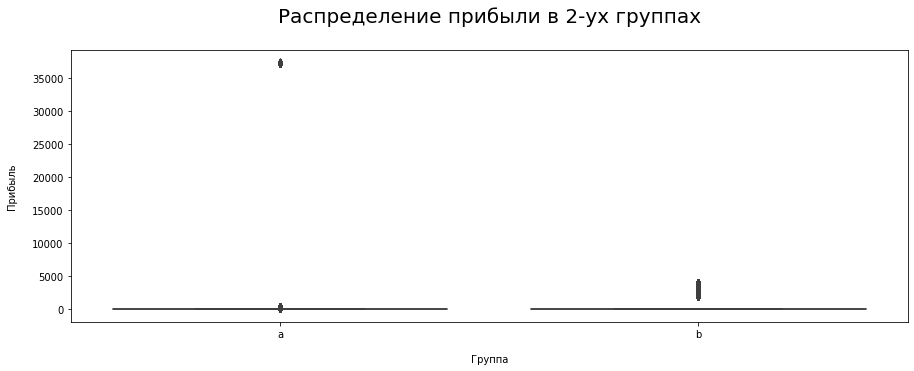

In [157]:
# Посмотрим на распределения прибыли в группах
# Размер графика
plt.figure(figsize=(15,5))
sns.boxplot(data=df_data, x='testgroup', y='revenue', order=['a', 'b'])


# Сделаем подписи к графику
plt.title('Распределение прибыли в 2-ух группах\n', size=20)
plt.ylabel('Прибыль', labelpad=15, size=10)
plt.xlabel('Группа', labelpad=15, size=10)

print("Боксплоты очень приплюснуты к нулю, в группе А наблюдаются выраженные выбросы.")

Text(0.5, 0, 'Прибыль')

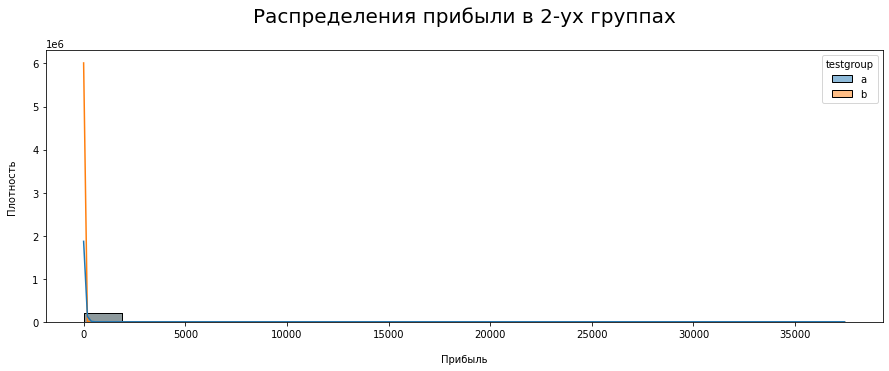

In [158]:
# Посмотрим на распределения прибыли в группах
# Размер графика
plt.figure(figsize=(15,5))
sns.histplot(data=df_data.sort_values("testgroup"), kde=True, hue="testgroup", x="revenue")

# Сделаем подписи к графику
plt.title('Распределения прибыли в 2-ух группах\n', size=20)
plt.ylabel('Плотность', labelpad=15, size=10)
plt.xlabel('Прибыль', labelpad=15, size=10)

In [159]:
# Посмотрим на численные значения прибыли у всех юзеров
# Среднее
df_data_mean_rev = df_data.groupby("testgroup", as_index=False).agg({"revenue":np.mean}).rename(columns={"revenue":"mean_revenue"})
# Медиана
df_data_median_rev = df_data.groupby("testgroup", as_index=False).agg({"revenue":np.median}).rename(columns={"revenue":"median_revenue"})
# Стандартное отклонение
df_data_std_rev = df_data.groupby("testgroup", as_index=False).agg({"revenue":np.std}).rename(columns={"revenue":"std_revenue"})
# Склеим
df_data__rev = df_data_mean_rev.merge(df_data_median_rev, on="testgroup", how="left")\
                                                                    .merge(df_data_std_rev, on="testgroup", how="left")
df_data__rev

,testgroup,mean_revenue,median_revenue,std_revenue
0,a,25.413720,0,920.768137
1,b,26.751287,0,287.324162


Из вышеуказанной таблицы можно заметить, что при средних отличающихся на 5.26%, среднеквадратичное отклонение очень разнится, отметим эту особенность для дальнейшего анализа прибыли (а именно её отклонений). Сравнивать медианы не получится. Тут можно сравнивать только средние значения (ttest).

<h5> Исследуем показатели всех клиентов

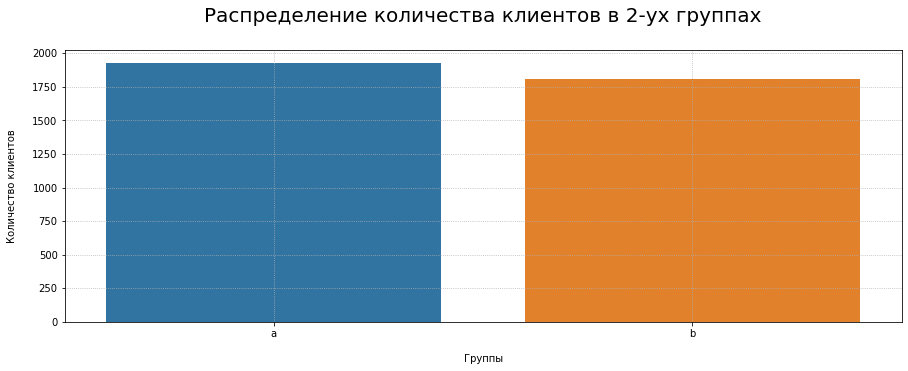

In [160]:
# Посмотрим как распределены клиенты (платящие пользователи в  двух группах) с помощью барплота
# Размер графика
plt.figure(figsize=(15,5))

# Данные с количеством клиентов по группам
df_data_clients = df_data.query("revenue != 0").groupby("testgroup", as_index=False).agg({"user_id":"count"})

# Барплот 
sns.barplot(data=df_data_clients, x='testgroup', y='user_id', order=['a', 'b'])

# Подписи названию и осям графика
plt.title('Распределение количества клиентов в 2-ух группах\n', size=20)
plt.ylabel('Количество клиентов', labelpad=15, size=10)
plt.xlabel('Группы', labelpad=15, size=10)

# Легенда
#plt.legend(title="Группа")

# Подписи меток осей
plt.xticks(fontsize=10) #range(len(labels)), labels, , rotation=45
plt.yticks(fontsize=10)

# Нарисуем сетку
plt.grid(visible=True, axis='both', linestyle=':')

На взгляд, разница в таком масштабе (где ось y начинается от 0) между кол-вом клиентов в группах заметна.

In [161]:
df_data_clients

,testgroup,user_id
0,a,1928
1,b,1805


Боксплоты очень приплюснуты к нулю, в группе А наблюдаются выраженные выбросы.


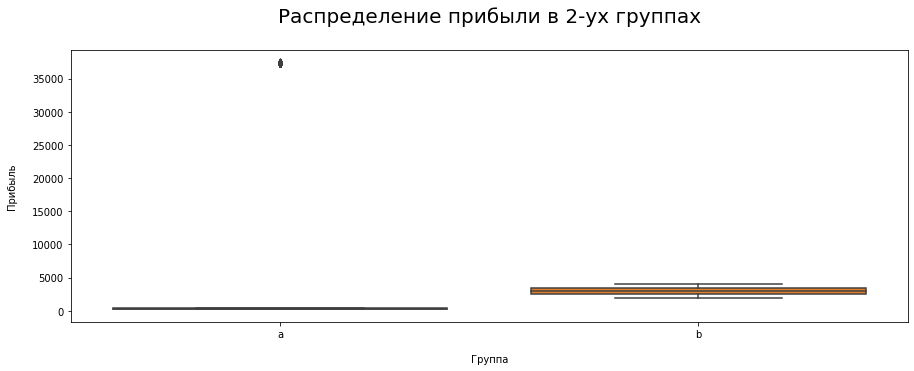

In [162]:
# Посмотрим на распределения прибыли в группах
# Размер графика
plt.figure(figsize=(15,5))
sns.boxplot( data=df_data.query('revenue != 0'), x='testgroup', y='revenue', order=['a', 'b'])


# Сделаем подписи к графику
plt.title('Распределение прибыли в 2-ух группах\n', size=20)
plt.ylabel('Прибыль', labelpad=15, size=10)
plt.xlabel('Группа', labelpad=15, size=10)

print("Боксплоты очень приплюснуты к нулю, в группе А наблюдаются выраженные выбросы.")

Распределения прибыли с пользователей в группе А не нормально, а вот уже в группе B похоже на нормальное,
проверим же распределения на нормальность и однородность дисперсий.


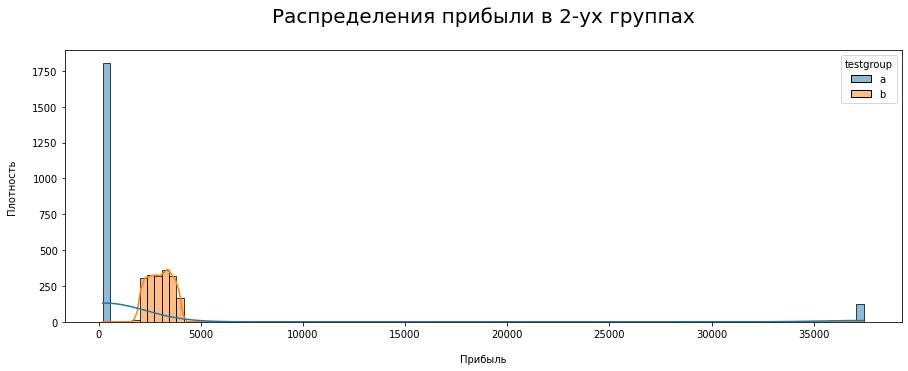

In [163]:
# Посмотрим на распределения прибыли в группах
# Размер графика
plt.figure(figsize=(15,5))
sns.histplot(data=df_data.query("purchase == True"), kde=True, hue="testgroup", x="revenue")

# Сделаем подписи к графику
plt.title('Распределения прибыли в 2-ух группах\n', size=20)
plt.ylabel('Плотность', labelpad=15, size=10)
plt.xlabel('Прибыль', labelpad=15, size=10)

print("Распределения прибыли с пользователей в группе А не нормально, а вот уже в группе B похоже на нормальное,")
print("проверим же распределения на нормальность и однородность дисперсий.")

In [164]:
# Посмотрим на численные значения прибыли у клиентов
# Среднее
df_data_mean_rev_c = df_data.query("revenue != 0").groupby("testgroup", as_index=False).agg({"revenue":np.mean}).rename(columns={"revenue":"mean_revenue"})
# Медиана
df_data_median_rev_c = df_data.query("revenue != 0").groupby("testgroup", as_index=False).agg({"revenue":np.median}).rename(columns={"revenue":"median_revenue"})
# Стандартное отклонение
df_data_std_rev_c = df_data.query("revenue != 0").groupby("testgroup", as_index=False).agg({"revenue":np.std}).rename(columns={"revenue":"std_revenue"})
# Склеим
df_data__rev_c = df_data_mean_rev_c.merge(df_data_median_rev_c, on="testgroup", how="left")\
                                                                    .merge(df_data_std_rev_c, on="testgroup", how="left")
df_data__rev_c

,testgroup,mean_revenue,median_revenue,std_revenue
0,a,2663.998444,311,9049.039763
1,b,3003.658172,3022,572.619709


Из вышеуказанной таблицы можно отметить, что при средних отличающихся на 12.75%, среднеквадратичное отклонение очень разнится, отметим эту особенность для дальнейшего анализа прибыли (а именно её отклонений). Тут можно сравнивать как средние значения (ttest) так и медианы (bootstrap).

In [165]:
print("В контрольной группе А наблюдается число платящих пользователей > 1000 = {} человек"
      .format(df_data_A.query("purchase == True and revenue > 1000").revenue.nunique()))
print("При этом revenue с каждого из этих пользователей от {} до {}."
      . format(
                       df_data_A.query("purchase == True and revenue > 1000").revenue.unique().min(),
                       df_data_A.query("purchase == True and revenue > 1000").revenue.unique().max()
                        ))

print("\nВ контрольной группе А наблюдается число платящих пользователей от 1 до 1000 = {} человек"
      .format(df_data_A.query("purchase == True and revenue > 0 and revenue < 1000").revenue.nunique()))
print("При этом revenue с каждого из этих пользователей от {} до {}."
      . format(
                       df_data_A.query("purchase == True and revenue > 0 and revenue < 1000").revenue.unique().min(),
                       df_data_A.query("purchase == True and revenue > 0 and revenue < 1000").revenue.unique().max()
                       ))

В контрольной группе А наблюдается число платящих пользователей > 1000 = 67 человек
При этом revenue с каждого из этих пользователей от 37293 до 37433.

В контрольной группе А наблюдается число платящих пользователей от 1 до 1000 = 201 человек
При этом revenue с каждого из этих пользователей от 200 до 400.


In [166]:
print("В тестовой группе B наблюдается число платящих пользователей > 1000 = {} человек"
      .format(df_data_B.query("purchase == True and revenue > 1000").revenue.nunique()))
print("При этом revenue с каждого из этих пользователей от {} до {}."
      . format(
                       df_data_B.query("purchase == True and revenue > 1000").revenue.unique().min(),
                       df_data_B.query("purchase == True and revenue > 1000").revenue.unique().max()
                       ))

print("\nВ контрольной группе B наблюдается число платящих пользователей от 1 до 1000 = {} человек"
      .format(df_data_B.query("purchase == True and revenue > 0 and revenue < 1000").revenue.nunique()))

В тестовой группе B наблюдается число платящих пользователей > 1000 = 1208 человек
При этом revenue с каждого из этих пользователей от 2000 до 4000.

В контрольной группе B наблюдается число платящих пользователей от 1 до 1000 = 0 человек


Исходя из представленных выше боксплотов, гистограмм и расчётов можно увидеть что:
- в обеих группах количество неплатящих пользователей велико по сравнению с платящими;
- в контрольной группе А наблюдается 67 человек, прибыль от каждого из которых более 37000, <br>
но при этом нет клиентов с прибылью от которых составляет от 2000 и до 4000,<br>
а есть 201 человек прибыль с которых составаляет от 200 до 400;
- в тестовой группе B наблюдаются 1208 человек, прибывыль от каждого из которых от 2000 и до 4000, <br>
но при этом нет клиентов с прибылью от которых составляет от 37000, а также от 200 до 400.
- так как в группах когорты платящих пользователей распределены не равномерно, то есть вопросы к системе сплитования;
- так же есть вероятность и ошибки записи данных в контрольную группу А <br>
(возможно клиенты с прибылью от них > 37000, должны были записаться без этих 37000 [т.е. вычесть из прибыли каждого клиента 37000],<br>и тогда бы они и попадали в диапазон 200-500), но это можно только лишь предполагать - ошибка ли это в записи данных,<br>
либо это реальная акционная стратегия (но порядки чисел подозрительно высокие).
- возможен и такой вариант: что с помощью такого A/B теста хотели проверить акционную стратегию различий между чеками большой-маленький и однородный, что порядки 37к это нормальные данные и есть клиенты, которые дают нам действительно такую прибыль (данные не сломаны).  

Т.е. непонятно - порядки 37к это сломанные данные (аномалия) или это действительно правильные данные доходов с клиента (вписывается в акционную стратегию), либо вообще нужно заново пересобирать группы из-за неравномерного распределения клиентов по группам ввиду доходов с них, <b>мы можем только гадать исходя из того что дано.<b>
Да и выкидывать из данных контрольной группы большую часть дохода (просто из-за возможной догатки глупо). Мы имеем что имеем, будем изучать то что есть! (Останемся с проверкой доходности большие-маленькие / однородные).

<b><i>Будем анализировать следующие метрики:
    - ARPU
    - ARPPU
    - CR

<h3><i>1) Рассмотрим метрику ARPU (количественная переменная)</h3>

In [167]:
print(f'Средняя выручка на пользователя в группе А = {ARPU_A.round(2)}')
print(f'Средняя выручка на пользователя в группе B = {ARPU_B.round(2)}')
print(f'Различия между средними выручками в группах = {delta_ARPU.round(2)}%')

Средняя выручка на пользователя в группе А = 25.41
Средняя выручка на пользователя в группе B = 26.75
Различия между средними выручками в группах = 5.26%


Выдвинем гипотезы:
    
- H0 - средн. значения выручек по пользователям между группами не отличаются;
- H1 - средн. значения выручек по пользователям между группами отличаются.

In [168]:
print("Распределения прибыли с пользователей в 2ух группах (на взгляд) являются ненормальными,")
print("проверим же распределения на нормальность и однородность дисперсий.")

Распределения прибыли с пользователей в 2ух группах (на взгляд) являются ненормальными,
проверим же распределения на нормальность и однородность дисперсий.


<h5>Размеры выборок

In [169]:
print(F"Размер выборки группы А =  {df_data_A.revenue.shape[0]}")
print(F"Размер выборки группы B =  {df_data_B.revenue.shape[0]}")

Размер выборки группы А =  202103
Размер выборки группы B =  202667


<h5>Проверим распределения на нормальность</h5>

Тест shapiro плохо реагирует на выборки большого размера, поэтому используем normaltest

In [170]:
ss.normaltest(df_data_A.revenue)

NormaltestResult(statistic=585152.7312728433, pvalue=0.0)

In [171]:
ss.normaltest(df_data_B.revenue)

NormaltestResult(statistic=326622.39540856465, pvalue=0.0)

Распределения в обеих группах не нормальные

<h5>Проверим распределения на однородность дисперсий</h5><br>

    
<li>Нулевая гипотеза - дисперсии гомогенны</li>
<li>Альтернативная гипотеза - дисперсии НЕ гомогенны</li>   

Проверим распределения через критерий Левена

In [172]:
ss.levene(df_data_A.revenue, df_data_B.revenue)

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

Дисперсии однородны, так как p-value > 0.05, то оставляем H0

На основе полученных данных (большие выборки, дисперсии однородны, распределения не нормальны) <b>можно использовать Т-тест Стъюдента<b>.

In [173]:
ss.ttest_ind(df_data_A.revenue, df_data_B.revenue)

Ttest_indResult(statistic=-0.6242026493616787, pvalue=0.532494858971837)

<h5>
Так как p-value > 0.05, то оставляем H0,
и делаем вывод - </h5>
    <br><b><i>Cредн. значения выручек по пользователям между группами стат.значимо неотличаются!

<h3><i>2) Рассмотрим метрику ARPPU (количественная переменная)</h3>

In [174]:
# Обозначим распределения
df_data_A_clients = df_data_A[df_data_A.revenue != 0]
df_data_B_clients = df_data_B[df_data_B.revenue != 0]

#Посчитаем ARPPU
ARPPU_A = df_data_A_clients.revenue.sum() / df_data_A_clients.user_id.nunique()
ARPPU_B = df_data_B_clients.revenue.sum() / df_data_B_clients.user_id.nunique()
delta_ARPPU = abs(1 - ARPPU_B / ARPPU_A) * 100

In [175]:
print(f'Средняя выручка на пользователя в группе А = {ARPPU_A.round(2)}')
print(f'Средняя выручка на пользователя в группе B = {ARPPU_B.round(2)}')
print(f'Различия между средними выручками в группах = {delta_ARPPU.round(2)}%')

Средняя выручка на пользователя в группе А = 2664.0
Средняя выручка на пользователя в группе B = 3003.66
Различия между средними выручками в группах = 12.75%


Выдвинем гипотезы:
    
- H0 - средн. значения выручек по клиентам между группами не отличаются;
- H1 - средн. значения выручек по клиентам между группами отличаются.

<h5>Размеры выборок

In [176]:
print(F"Размер выборки группы А =  {df_data_A_clients.revenue.shape[0]}")
print(F"Размер выборки группы B =  {df_data_B_clients.revenue.shape[0]}")

Размер выборки группы А =  1928
Размер выборки группы B =  1805


<h5>Проверим распределения на нормальность</h5>

Тест shapiro плохо реагирует на выборки большого размера, поэтому используем normaltest

In [177]:
ss.normaltest(df_data_A_clients.revenue)

NormaltestResult(statistic=1394.9457843086925, pvalue=1.2341605505935488e-303)

In [178]:
ss.normaltest(df_data_B_clients.revenue)

NormaltestResult(statistic=1068.8600084412267, pvalue=7.943249488371762e-233)

Распределения в обеих группах не нормальные, тк pvalue < 0.05

<h5>Проверим распределения на однородность дисперсий</h5><br>

    
<li>Нулевая гипотеза - дисперсии гомогенны</li>
<li>Альтернативная гипотеза - дисперсии НЕ гомогенны</li>   

Проверим распределения через критерий Левена

In [179]:
ss.levene(df_data_A_clients.revenue, df_data_B_clients.revenue)

LeveneResult(statistic=80.85567421779912, pvalue=3.779689868667878e-19)

Дисперсии неоднородны, так как p-value < 0.05, то отклоняем H0

На основе полученных данных (большие выборки, дисперсии неоднородны, распределения не нормальны) <b>можно использовать Т-тест Уэлча для неоднородных дисперсий в распределениях</b>.

In [180]:
# equal_var=False - т-критерий Уэлча
ss.ttest_ind(df_data_A_clients.revenue, df_data_B_clients.revenue, equal_var=False)

Ttest_indResult(statistic=-1.6446302664300838, pvalue=0.10020780398916015)

<h5>
Так как p-value > 0.05, то оставляем H0,
и делаем вывод - </h5>
    <br><i><b>Cредн. значения выручек по клиентам между группами стат.значимо неотличаются!

<h3><i>3) Рассмотрим метрику CR (качественная переменная)</h3>
    
Конверсия пользователя в клиента (платёж)

In [181]:
#  Создадим таблицу с CR
df_data_cr1 = pd.DataFrame({
                                'testgroup' : ['a','b'],
                                'cr1' :       [CR1_A, CR1_B]
                            })
df_data_cr1

,testgroup,cr1
0,a,0.009540
1,b,0.008906


In [182]:
# Создадим кросс таблицу с количеством пользователей и клиентов по группам
df_data_count_users = df_data.groupby(["testgroup", 'purchase'], as_index=False).agg({'user_id':"count"})
df_data_crosstab_cr = pd.crosstab(df_data.purchase, df_data.testgroup, values='user_id', aggfunc='count')
df_data_crosstab_cr

testgroup,a,b
purchase,,
False,200175,200862
True,1928,1805


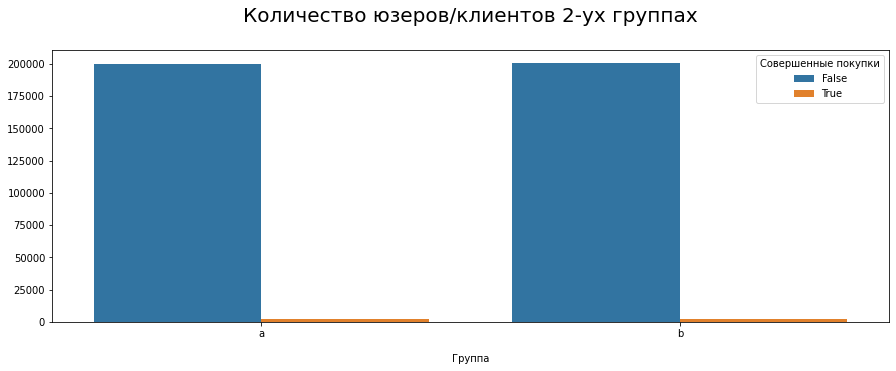

In [183]:
# Размер графика
plt.figure(figsize=(15,5))
sns.barplot(data=df_data_count_users, x='testgroup',y='user_id', hue="purchase")

# Сделаем подписи к графику
plt.title('Количество юзеров/клиентов 2-ух группах\n', size=20)
plt.ylabel('', labelpad=15, size=10)
plt.xlabel('Группа', labelpad=15, size=10)


# Легенда
plt.legend(title="Cовершенные покупки")

Выдвинем гипотезы для использования <i><b>критерия Хи-квадрат</i></b> для категориальной переменной "purchase":
    
- H0 - различий в CR нет;
- H1 - различия в CR есть.

<i><b>Для использования критерия Хи-квадрат выполняются следующие условия</i></b>:
1. Все наблюдения независимы;
2. Количество наблюдений в каждой группе > 5.

In [184]:
df_data_count_users.query("testgroup == 'b'")

,testgroup,purchase,user_id
2,b,False,200862
3,b,True,1805


In [185]:
chi2_stat, pvalue, degrees_of_freedom, expected_freq  = ss.chi2_contingency(df_data_crosstab_cr)
chi2_stat, pvalue, degrees_of_freedom

(4.374729521260405, 0.03647561892312613, 1)

In [186]:
pvalue < 0.05

True

<h5>
Так как p-value < 0.05, то отклоняем H0,
и делаем вывод - </h5>
    <br><i><b>статзначимые различия в CR есть. Т.е. в контрольной группе А - CR выше.

<h4>Вывод по Заданию 2</h4>

В ходе задания, был реализован анализ данных, в котором двум группам пользователей предлагались различные наборы акционных предложений.<br>
Были рассмотрены метрики:
- ARPU (средний доход с пользователей хоть и выше в группе 'b'-тестовой по сравнению с группой 'a'-контрольной на 5.26%, но статистически незначим);
- ARPPU (средний доход с клиентов хоть и выше в группе 'b'-тестовой по сравнению с группой 'a'-контрольной на 12.75%, но статистически незначим);
- CR (обнаружены статзначимые различия в пользу контрольной группы). 

На основе анализа вышеуказанных метрик, можно сделать однозначный вывод в пользу контрольной группы. Возможно выборки были сделаны криво, неравномерно, система сплитования работала плохо, а так же мы не знаем точно ли выдохий доход с нескольких пользователей в контрольной группе достоверен или это баг записи данных.<br>
Тестовая группа показала хуже конверсию в клиенты, а средние доходы с пользователей/клиентов одинаковы. <br>
Стоит провести анализ системы сплитования юзеров и АА-тесты, тк в контрольной группе больше и пользователей и клиентов, 123 клиента дают очень высокий доход, который покрывает около 90% дохода всей контрольной группы.
Стоит и иметь ввиду, издержки на издержки требующиеся на полноценное внедрение той или иной акционной кампании на постоянной основе.<br>

<b>Не выкатаваем тестовый набор акционных предложений, остаёмся с контрольным. А так же исследуеем сами данные и систему сплитования. тестовой группе!</b>

### Задание 3

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. <br>
В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. <br>
Для получения награды требуется пройти ряд уровней за определенное время. <br>
С помощью каких метрик можно оценить результаты последнего прошедшего события?



Метрики:
1. СR (conversion rate) - Воронка юзеров в выполнение ключевого действия. Причем можно рассчитывать как абсолютную CR (доля юзеров прошедших все уровни к юзерам пришедшим в тематическое событие) так и относительную CR (отражает долю юзеров относительного каждого уровня/шага). CR помогает оценить вовлеченность/интерес юзеров в сотытие, сложность уровней, количество юзеров завершивших все уровни и получивших призы.
2. RR (retention rate) - % удержания клиентов в разрезе месяца на каждый день включая событие. Можно рассчитать юзеров возвращающися в продукт с началом/концом/каджым последующим днём события. Показывает интерес к событию и его падение с каждым новым днём, а также насколько успешно после окончания события игроки удерживаются в игре.
3. MAU (monthly auditory) - Позволяет узнать количество уникальных пользователей зашедших за месяц в игру.
4. avgDAU (average daily auditory) - Позволяет узнать среднее количество уникальных пользователей заходящих в игру каждый день.
5. avgDAU/MAU (stickness ratio) - Как часто юзеры остаются в игре на протяжении месяца.
6. ARPU (average revenue per paying user) - Среднее количество денег на юзера, т.е. можно оченить успешность события относительно денежных величин, если есть платные элементы внутри/связанные с событием (мерч, лутбоксы, компендиумы итд). Опять же эта метрика еще может иметь относительных характер если её сравнивать с такой же в периоды месяцев с другими событиями или вообще без событий.
7. ASL (average session length) - Позволяет понять сколько в среднем времени юзер проводит в игре, также позволяет судить о сложности уровней/вовлеченности в событие.
8. Количество новых игровков - Число новых (привлечённых событием) юзеров каждый день.
9. Среднее кол-во уровней, пройденных игроками - в комбинации с ASL позволяет судить о сложности уровня и среднем времени напрохождение каждого уровня.



Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке <br>
выполнения уровня игрок будет откатываться на несколько уровней назад. <br>
Изменится ли набор метрик оценки результата? Если да, то как?

Метрики могут изменяться:
1. СR (conversion rate). Могут снизиться абсолютные и относительные показатели. Из-за сложности события юзеры или не смогут дойти до конца события или будет их отток от события ввиду сложности и потери мотивации/интереса.
2. RR (retention rate). Может также снижаться более выраженно за каждый последующий день события. А также можно применить обратную метрику - churn rate.
3. MAU - эта метрика может и не быть наглядной в разрезе целого месяца.
4. avgDAU (average daily auditory). Также может значительно снизиться из-за сложности упадет мотивация, и возможность получения приза.
5. avgDAU/MAU (stickness ratio). Вслед за avgDAU снизится.
6. ASL (average session length. Игроки будут меньше проводить времени в событии из-за сложности. Также будет несколько выбросов с игроками дошедших  до конца, прошедших все уровни с удлинённым временем.
7. Количество новых игроков. Может и не сильно поменяться, а то и отстаться таким же, факт события все равно будет привлекаться новых уникальных юзеров.
8. Среднее кол-во уровней, пройденных игроками - в комбинации с ASL позволяет судить о сложности уровня и среднем времени напрохождение каждого уровня. Эти метрики упадут.

<h4>Вывод по Заданию 3</h4>

Метрики продукта выбираются исходя из специфики самого продукта, ожидания частоты его использования, тех данных которые хотям видеть. Важно учитывать, при изменении структуры события (сложность уровней и отведенного времени), изменения метрик, так как это может изменить мотивацию, вовлеченность, возвращаемость игроков в игру, а также приносимую ими прибыль. Важно поддерживать интерес юзеров, а не угнетать их своими действиями.